<a href="https://colab.research.google.com/github/aleksandarmanev01/thesis-spam-detection/blob/main/src/bert/BERT_TextClassifier_SD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Package Installation

In [ ]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 30.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 35.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 76.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 73.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 35.1 MB/s eta 0:00:00


# Define common functionality

**Imports**

In [ ]:
# Standard Libraries for Data Manipulation
import os
import pandas as pd
import numpy as np

# Machine Learning Utilities
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
import matplotlib.pyplot as plt

# PyTorch Libraries for Deep Learning
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.nn import CrossEntropyLoss
from torch.optim import AdamW

# Hugging Face Transformers for NLP
from transformers import BertTokenizer, BertForSequenceClassification, get_linear_schedule_with_warmup

**Data preparation**

In [ ]:
# Constants
BERT_PRETRAINED_MODEL = 'bert-base-uncased'
DEFAULT_MAX_LENGTH = 64
DEFAULT_BATCH_SIZE = 32

In [ ]:
def prepare_data(train_df, val_df):
    """
    Reset indices for dataframes, separate features and labels, and display label distribution.

    Args:
    - train_df (pd.DataFrame): DataFrame containing the training data.
    - val_df (pd.DataFrame): DataFrame containing the validation data.

    Returns:
    - X_train (pd.Series): Messages for training data.
    - y_train (pd.Series): Labels for training data.
    - X_val (pd.Series): Messages for validation data.
    - y_val (pd.Series): Labels for validation data.
    """

    # Reset indices of both dataframes
    train_df = train_df.reset_index(drop=True)
    val_df = val_df.reset_index(drop=True)

    # Separate the features and labels for training and testing data
    X_train, y_train = train_df['message'], train_df['label']
    X_val, y_val = val_df['message'], val_df['label']

    # Print the label distribution for both training and validation sets
    print("Training set label distribution:")
    print(y_train.value_counts())
    print("\nValidation set label distribution:")
    print(y_val.value_counts())

    return X_train, y_train, X_val, y_val

In [ ]:
# Function to tokenize data
def tokenize_data(texts, labels, tokenizer, max_length=DEFAULT_MAX_LENGTH):
    """
    Tokenize text data using a specified tokenizer.

    Args:
    - texts (pd.Series): Text data to tokenize.
    - labels (pd.Series): Corresponding labels.
    - tokenizer: Tokenizer instance to use.
    - max_length (int): Maximum length for tokenized sequences.

    Returns:
    - tuple: Contains input IDs, attention masks, and labels as tensors.
    """
    input_ids = []
    attention_masks = []

    for sentence in texts:
        encoded_dict = tokenizer.encode_plus(
            sentence,
            add_special_tokens=True,
            max_length=max_length,
            truncation=True,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
        )
        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])

    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    labels = torch.tensor(labels.values)

    return input_ids, attention_masks, labels

In [ ]:
def prepare_dataloaders(X_train, y_train, X_val, y_val, batch_size=DEFAULT_BATCH_SIZE):
    """
    Prepare dataloaders for training and validation sets.

    Args:
    - X_train (pd.Series): Training input data
    - y_train (pd.Series): Training labels
    - X_val (pd.Series): Validation input data
    - y_val (pd.Series): Validation labels
    - batch_size (int): Batch size for DataLoader (default: 32)

    Returns:
    - train_dataloader: DataLoader for the training set
    - validation_dataloader: DataLoader for the validation set
    """

    # Initialize the tokenizer
    tokenizer = BertTokenizer.from_pretrained(BERT_PRETRAINED_MODEL, do_lower_case=True)

    # Tokenize and prepare DataLoader for the training set
    input_ids_train, attention_masks_train, labels_train = tokenize_data(X_train, y_train, tokenizer)
    train_data = TensorDataset(input_ids_train, attention_masks_train, labels_train)
    train_dataloader = DataLoader(train_data, sampler=RandomSampler(train_data), batch_size=batch_size)

    # Tokenize and prepare DataLoader for the validation set
    input_ids_val, attention_masks_val, labels_val = tokenize_data(X_val, y_val, tokenizer)
    validation_data = TensorDataset(input_ids_val, attention_masks_val, labels_val)
    validation_dataloader = DataLoader(validation_data, sampler=SequentialSampler(validation_data), batch_size=batch_size)

    return train_dataloader, validation_dataloader

**Training function**


In [ ]:
def train_one_epoch(model, dataloader, optimizer, scheduler, device, loss_fct):
    """
    Train the model for one epoch.

    Args:
    - model: The model to train.
    - dataloader (DataLoader): DataLoader for the training data.
    - optimizer: The optimizer.
    - scheduler: Learning rate scheduler.
    - device: The device (CPU/GPU) to use for training.
    - loss_fct: Loss function to compute the loss.

    Returns:
    - avg_train_loss (float): Average training loss.
    - train_predictions (list): Predictions on the training data.
    - train_true_labels (list): True labels of the training data.
    """
    # Ensure the model is in train mode and moved to the appropriate device
    model.train().to(device)

    # Lists to store predictions and true labels for evaluation
    train_predictions, train_true_labels = [], []

    # Variable to store total training loss
    total_train_loss = 0

    for step, batch in enumerate(dataloader):
        # Move batch tensors to the device in use
        b_input_ids, b_input_mask, b_labels = tuple(t.to(device) for t in batch)

        # Clear any previously calculated gradients for the model
        model.zero_grad()

        # Forward pass
        outputs = model(b_input_ids, attention_mask=b_input_mask)
        logits = outputs.logits

        # Compute loss using the specified loss function
        loss = loss_fct(logits.view(-1, 2), b_labels.view(-1))

        # Backward pass
        loss.backward()

        # Update weights using the optimizer and update the learning rate
        optimizer.step()
        scheduler.step()

        # Accumulate the total loss
        total_train_loss += loss.item()

        # Get predictions and true labels for evaluation later
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        train_predictions.extend(np.argmax(logits, axis=1).flatten())
        train_true_labels.extend(label_ids.flatten())

    # Calculate average training loss over all batches
    avg_train_loss = total_train_loss / len(dataloader)

    return avg_train_loss, train_predictions, train_true_labels

**Evaluation function**

In [ ]:
def evaluate(model, dataloader, device, loss_fct):
    """
    Evaluate the model on the given data.

    Args:
    - model: The model to evaluate.
    - dataloader (DataLoader): DataLoader for the evaluation data.
    - device: The device (CPU/GPU) to use for evaluation.
    - loss_fct: Loss function to compute the loss.

    Returns:
    - avg_val_loss (float): Average evaluation loss.
    - val_predictions (list): Predictions on the evaluation data.
    - val_true_labels (list): True labels of the evaluation data.
    """

    # Ensure the model is in evaluation mode and moved to the appropriate device
    model.eval().to(device)

    # Lists to store predictions and true labels for evaluation
    val_predictions, val_true_labels = [], []

    # Variable to store total validation loss
    total_val_loss = 0

    # Disable gradient computation during evaluation to save memory and speed up computation
    with torch.no_grad():
        for batch in dataloader:
            # Move batch tensors to the device in use
            b_input_ids, b_input_mask, b_labels = tuple(t.to(device) for t in batch)

            # Forward pass
            outputs = model(b_input_ids, attention_mask=b_input_mask)
            logits = outputs.logits

            # Compute loss using the specified loss function
            loss = loss_fct(logits.view(-1, 2), b_labels.view(-1))

            # Accumulate the validation loss
            total_val_loss += loss.item()

            # Get predictions and true labels for evaluation later
            logits = logits.detach().cpu().numpy()
            label_ids = b_labels.to('cpu').numpy()
            val_predictions.extend(np.argmax(logits, axis=1).flatten())
            val_true_labels.extend(label_ids.flatten())

    # Calculate average validation loss over all batches
    avg_val_loss = total_val_loss / len(dataloader)

    return avg_val_loss, val_predictions, val_true_labels

**Model definition**

In [ ]:
# Hyperparameters as constants
LEARNING_RATE = 2e-5
EPSILON = 1e-8
NUM_LABELS = 2
NUM_EPOCHS = 10
FREEZE_BERT = False

MAX_PATIENCE = 3

In [ ]:
def initialize_training_components(train_dataloader, y_train, learning_rate, epsilon, num_labels, num_epochs, freeze_bert):
    """
    Initialize training components including model, optimizer, scheduler, and loss function.

    Args:
    - train_dataloader: DataLoader for the training set.
    - y_train: Training labels.
    - learning_rate: Learning rate for the optimizer.
    - epsilon: Epsilon parameter for the optimizer.
    - num_labels: Number of output labels for classification.
    - num_epochs: Number of epochs for training.
    - freeze_bert: Flag to decide whether to freeze the BERT base model.

    Returns:
    - model: Initialized BERT model for sequence classification.
    - optimizer: Initialized AdamW optimizer.
    - scheduler: Initialized scheduler.
    - loss_fct: Cross entropy loss function with class weights.
    """

    # Initialize BERT for Sequence Classification model
    model = BertForSequenceClassification.from_pretrained(
        'bert-base-uncased',
        num_labels=num_labels,
        output_attentions=False,
        output_hidden_states=False,
    )

    # Optional: Freeze all parameters in the BERT base model to keep them from training
    # (in order to train the classification head only)
    if freeze_bert:
        for param in model.bert.parameters():
            param.requires_grad = False

    # Initialize the AdamW optimizer
    optimizer = AdamW(model.parameters(), lr=learning_rate, eps=epsilon)
    total_steps = len(train_dataloader) * num_epochs

    # Initialize learning rate scheduler
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

    # Calculate class weights based on their frequencies in the training data
    weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    class_weights = torch.tensor(weights, dtype=torch.float32).to(device)

    # Initialize the cross-entropy loss function with class weights
    loss_fct = torch.nn.CrossEntropyLoss(weight=class_weights)

    return model, optimizer, scheduler, loss_fct

**Training and evaluation pipeline**

In [ ]:
def log_to_file(log_file_path, content):
    """Helper function to log content to a file."""
    with open(log_file_path, 'a') as log_file:
        log_file.write(content)

In [ ]:
def train_with_early_stopping(model, train_dataloader, validation_dataloader, optimizer, scheduler, device, loss_fct, scenario, dataset_name, log_file_path, epochs=NUM_EPOCHS, max_patience=MAX_PATIENCE):
    """
    Train the model with early stopping.

    Args:
    - model: The BERT model for sequence classification.
    - train_dataloader: DataLoader for the training set.
    - validation_dataloader: DataLoader for the validation set.
    - optimizer: The optimizer.
    - scheduler: The learning rate scheduler.
    - device: torch device (cuda or cpu).
    - loss_fct: The loss function.
    - epochs: Number of maximum training epochs (default is NUM_EPOCHS).
    - max_patience: Number of epochs to wait for improvement in validation loss before stopping (default is MAX_PATIENCE).

    Returns:
    - train_loss_set: List of average training losses for each epoch.
    - val_loss_set: List of average validation losses for each epoch.
    - train_f1_set: List of training F1 scores for each epoch.
    - val_f1_set: List of validation F1 scores for each epoch.
    """

    # Initialize variables for early stopping
    best_val_loss = float("inf")
    patience = 0

    # Lists to keep track of epoch-wise training and validation metrics
    train_loss_set, val_loss_set, train_f1_set, val_f1_set = [], [], [], []

    # Training loop
    for epoch in range(epochs):
        # Training
        avg_train_loss, train_predictions, train_true_labels = train_one_epoch(model, train_dataloader, optimizer, scheduler, device, loss_fct)

        # Validation
        avg_val_loss, val_predictions, val_true_labels = evaluate(model, validation_dataloader, device, loss_fct)

        train_loss_set.append(avg_train_loss)
        val_loss_set.append(avg_val_loss)

        train_f1 = f1_score(train_true_labels, train_predictions)
        val_f1 = f1_score(val_true_labels, val_predictions)

        train_f1_set.append(train_f1)
        val_f1_set.append(val_f1)

        # Print and write the results to the log file
        log_data = (
          f"Epoch {epoch + 1}\n"
          f"Average Training Loss: {avg_train_loss:.4f} | "
          f"Training F1-Score: {train_f1:.4f}\n"
          f"Average Validation Loss: {avg_val_loss:.4f} | "
          f"Validation F1-Score: {val_f1:.4f}\n"
          f"{'-' * 60}\n"
        )

        # print(log_data)
        log_to_file(log_file_path, log_data)

        # Early stopping logic
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            # Save the model
            torch.save(model.state_dict(), 'best_model.pth')
            patience = 0
        else:
            patience += 1
            if patience >= max_patience:
                print(f"Early stopping after {epoch + 1} epochs.")
                break

    return train_loss_set, val_loss_set, train_f1_set, val_f1_set

**Save predictions**

In [ ]:
def save_predictions_and_labels(messages, predictions, labels, model_name, scenario, dataset_name, run_id):
    """
    Save model predictions and true labels to a CSV file.
    """
    directory = f"drive/MyDrive/Bachelor's Thesis/Spam detection/bert/predictions/{run_id}/{scenario}/{dataset_name}"

    # Create directories if they don't exist
    if not os.path.exists(directory):
        os.makedirs(directory)

    path = f"{directory}/{model_name}.csv"
    df = pd.DataFrame({
        'message': messages,
        'predicted_label': predictions,
        'true_label': labels
    })
    df.to_csv(path, index=False)

**Define scenarios and configure data**

In [ ]:
AUGMENTED_SPAM_FILES = [f"drive/MyDrive/Bachelor's Thesis/Spam detection/data/Augmentation/Spam/augmented_spam_{i}.csv" for i in range(1, 6)]
AUGMENTED_MIXED_FILES = [f"drive/MyDrive/Bachelor's Thesis/Spam detection/data/Augmentation/Mixed/augmented_mixed_{i}.csv" for i in
                         [5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]]
GENERATED_FILES = [f"drive/MyDrive/Bachelor\'s Thesis/Spam detection/data/Generation/generated_{i}_each.csv" for i in
                   [350, 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000]]

scenarios = {
    'Scenario_OAS_O': AUGMENTED_SPAM_FILES,
    'Scenario_OAM_O': AUGMENTED_MIXED_FILES,
    'Scenario_AM_O': AUGMENTED_MIXED_FILES,
    'Scenario_AM_F': AUGMENTED_MIXED_FILES,
    'Scenario_OGM_O': GENERATED_FILES,
    'Scenario_GM_O': GENERATED_FILES,
    'Scenario_GM_F': GENERATED_FILES
}


def config_scenario(generated_data, original_train, original_test, scenario_type):
    """
       Configure the training and test datasets based on the specified scenario type.

       Parameters:
       - generated_data (DataFrame): The dataframe containing the generated or augmented data.
       - original_train (DataFrame): The dataframe containing the original training data.
       - original_test (DataFrame): The dataframe containing the original test data.
       - scenario_type (str): The type of scenario to configure datasets for.

       Returns:
       - train (DataFrame): Configured training data for the scenario.
       - test (DataFrame): Configured test data for the scenario.
       """
    if scenario_type == "Scenario_OAM_O" or scenario_type == "Scenario_OAS_O" or scenario_type == "Scenario_OGM_O":
        train = pd.concat([original_train, generated_data], axis=0).sample(frac=1).reset_index(drop=True)
        test = original_test
    elif scenario_type == "Scenario_AM_O" or scenario_type == "Scenario_GM_O":
        train = generated_data.sample(frac=1).reset_index(drop=True)
        test = original_test
    elif scenario_type == "Scenario_AM_F" or scenario_type == "Scenario_GM_F":
        train = generated_data.sample(frac=1).reset_index(drop=True)
        test = pd.concat([original_train, original_test], axis=0).sample(frac=1).reset_index(drop=True)
    else:
        raise ValueError(f"Unknown scenario type: {scenario_type}")

    return train, test

**Plot training results**

In [ ]:
def plot_training_results(train_loss, val_loss, train_f1, val_f1, scenario, dataset_label, run_id, save=False):
    """
    Plot training and validation loss and F1 score.

    Parameters:
    - train_loss (list): List of training loss over epochs.
    - val_loss (list): List of validation loss over epochs.
    - train_f1 (list): List of training F1 scores over epochs.
    - val_f1 (list): List of validation F1 scores over epochs.
    - scenario (str): Name of scenario being evaluated.
    - dataset_label (str): Label for the dataset being used.
    - save (bool): If True, save the plots to disk.
    """

    SAVE_DIR = f"drive/MyDrive/Bachelor's Thesis/Spam detection/bert/training_data/training_plots/{run_id}/"

    # If save directory doesn't exist, create it
    if not os.path.exists(SAVE_DIR):
        os.makedirs(SAVE_DIR)

    # Plot training and validation loss
    plt.figure(figsize=(10, 5))
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title(f'Loss over Epochs for BERT with {scenario} on {dataset_label}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)

    if save:
        loss_save_path = os.path.join(SAVE_DIR, f'{scenario}_{dataset_label}_loss_plot.png')
        plt.savefig(loss_save_path)
    plt.show()

    # Plot training and validation F1 score
    plt.figure(figsize=(10, 5))
    plt.plot(train_f1, label='Training F1 Score')
    plt.plot(val_f1, label='Validation F1 Score')
    plt.title(f'F1 Score over Epochs for BERT with {scenario} on {dataset_label}')
    plt.xlabel('Epochs')
    plt.ylabel('F1 Score')
    plt.legend()
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)

    if save:
        f1_save_path = os.path.join(SAVE_DIR, f'{scenario}_{dataset_label}_f1_plot.png')
        plt.savefig(f1_save_path)
    plt.show()

**Model evaluation**

In [ ]:
def train_and_evaluate_bert(scenario_name, train_df, test_df, dataset_name, log_file_path, run_id, file_path=None):
    """
    Train and evaluate the BERT model for the given scenario and dataset.
    """
    # Add a header line with the model name, scenario, and dataset name
    header_line = (
      f"\n\nModel Name: BERT\n"
      f"Scenario: {scenario_name}\n"
      f"Dataset: {dataset_name}\n"
      f"{'=' * 80}\n"
    )
    log_to_file(log_file_path, header_line)

    # Prepare data for model input
    X_train, y_train, X_val, y_val = prepare_data(train_df, test_df)
    train_dataloader, validation_dataloader = prepare_dataloaders(X_train, y_train, X_val, y_val)

    # Setup the model for training
    model, optimizer, scheduler, loss_fct = initialize_training_components(
        train_dataloader, y_train,
        LEARNING_RATE, EPSILON, NUM_LABELS, NUM_EPOCHS, FREEZE_BERT
    )
    model.to(device)

    # Train the model
    train_loss_set, val_loss_set, train_f1_set, val_f1_set = train_with_early_stopping(
        model,
        train_dataloader,
        validation_dataloader,
        optimizer,
        scheduler,
        device,
        loss_fct,
        scenario=scenario_name,
        dataset_name=dataset_name,
        log_file_path=log_file_path
    )

    # Plotting the results
    plot_training_results(train_loss_set, val_loss_set, train_f1_set, val_f1_set, scenario_name, dataset_name, run_id, save=True)

    # Load the best model for evaluation
    model.load_state_dict(torch.load('best_model.pth'))

    # Evaluation
    _, all_preds, all_labels = evaluate(model, validation_dataloader, device, loss_fct)

    # Save predictions and labels
    save_predictions_and_labels(test_df['message'].values, all_preds, all_labels, 'BERT', scenario_name, dataset_name, run_id)

    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    f1_macro = f1_score(all_labels, all_preds, average='macro')
    f1_weighted = f1_score(all_labels, all_preds, average='weighted')
    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)

    # Results and Logging
    results = []
    results.append(f"\nTraining for BERT with scenario {scenario_name} and dataset {dataset_name} has finished.\n")
    results.append(f'Accuracy on Validation Set: {accuracy}\n')
    results.append(f'Precision on Validation Set: {precision}\n')
    results.append(f'Recall on Validation Set: {recall}\n')
    results.append(f'F1 Score on Validation Set (binary): {f1}\n')
    results.append(f'F1 Score on Validation Set (macro): {f1_macro}\n')
    results.append(f'F1 Score on Validation Set (weighted): {f1_weighted}\n')

    for line in results:
        print(line)
        log_to_file(log_file_path, line)

    # Cleanup
    del model
    torch.cuda.empty_cache()

    return

# Main

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Read the original dataset
data_df = pd.read_csv("drive/MyDrive/Bachelor's Thesis/Spam detection/data/sms_spam_dataset.csv")
data_df['label'] = data_df['label'].map({'ham': 0, 'spam': 1})

# Split the dataset into training and validation data
train_df_original, val_df_original = train_test_split(data_df, test_size=0.2, random_state=42, stratify=data_df['label'])

Evaluating Scenario_OAS_O with dataset original...
Training set label distribution:
0    3859
1     598
Name: label, dtype: int64

Validation set label distribution:
0    966
1    149
Name: label, dtype: int64


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Early stopping after 8 epochs.


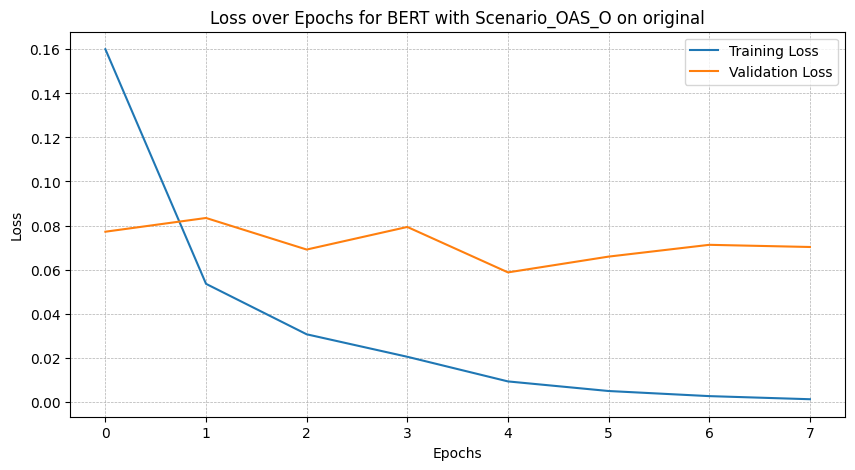

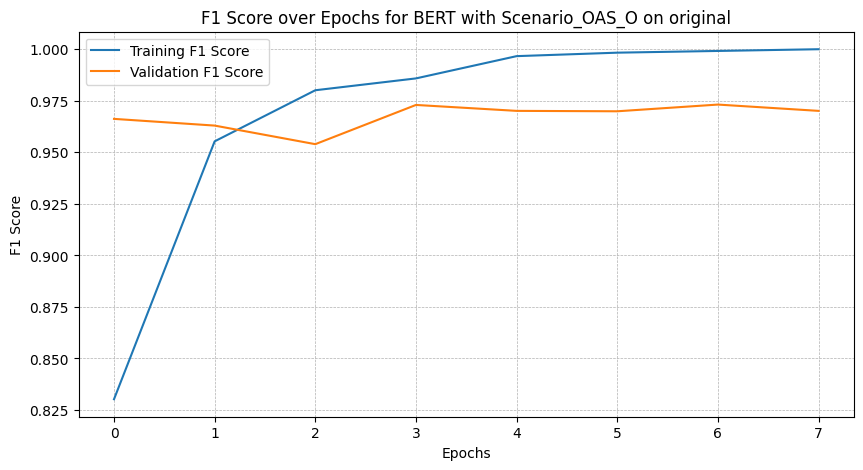


Training for BERT with scenario Scenario_OAS_O and dataset original has finished.

Accuracy on Validation Set: 0.9919282511210762

Precision on Validation Set: 0.9605263157894737

Recall on Validation Set: 0.9798657718120806

F1 Score on Validation Set (binary): 0.9700996677740865

F1 Score on Validation Set (macro): 0.9827170189570277

F1 Score on Validation Set (weighted): 0.9919621991511648

Evaluating Scenario_OAS_O with dataset augmented_spam_1...
Training set label distribution:
0    3859
1    1196
Name: label, dtype: int64

Validation set label distribution:
0    966
1    149
Name: label, dtype: int64


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Early stopping after 5 epochs.


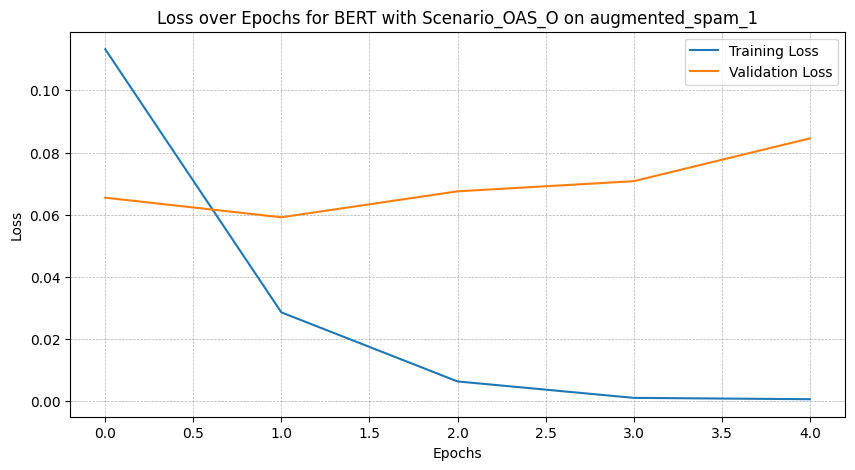

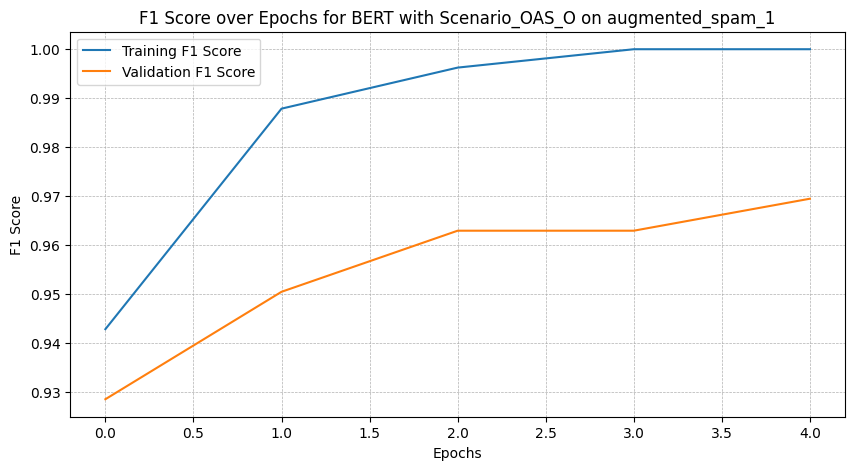


Training for BERT with scenario Scenario_OAS_O and dataset augmented_spam_1 has finished.

Accuracy on Validation Set: 0.9865470852017937

Precision on Validation Set: 0.935064935064935

Recall on Validation Set: 0.9664429530201343

F1 Score on Validation Set (binary): 0.9504950495049505

F1 Score on Validation Set (macro): 0.9713554645552775

F1 Score on Validation Set (weighted): 0.9866406296639028

Evaluating Scenario_OAS_O with dataset augmented_spam_2...
Training set label distribution:
0    3859
1    1794
Name: label, dtype: int64

Validation set label distribution:
0    966
1    149
Name: label, dtype: int64


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
run_id = "Run_6"
# Define the path for the log file
log_file_path = f"drive/MyDrive/Bachelor's Thesis/Spam detection/bert/training_data/training_log_{run_id}.txt"

for scenario_name, files in scenarios.items():
    # Check if the scenario is one of the specified
    if scenario_name in ['Scenario_OAM_O', 'Scenario_OAS_O', 'Scenario_OGM_O']:
        dataset_name = "original"
        print(f"Evaluating {scenario_name} with dataset {dataset_name}...")
        train_and_evaluate_bert(scenario_name, train_df_original, val_df_original, dataset_name, log_file_path, run_id)

    for file_path in files:
        # Load the generated or augmented data
        generated_data = pd.read_csv(f'{file_path}')
        generated_data['label'] = generated_data['label'].map({'ham': 0, 'spam': 1})

        # Configure scenario to get train and test data
        train_df, test_df = config_scenario(generated_data, train_df_original, val_df_original, scenario_name)

        dataset_name = file_path.split('/')[-1].replace('.csv', '')
        print(f"Evaluating {scenario_name} with dataset {dataset_name}...")
        train_and_evaluate_bert(scenario_name, train_df, test_df, dataset_name, log_file_path, run_id, file_path)